# Question Exploration

In [30]:
# Imports

import pymssql
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Reading in data

In [31]:
# Credentials
# Functions to read from database and join tables

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

all_df = run_queries()
master_table = join_tables(all_df)

5607
5607
5607
20727


#### Exploratory Data Analysis

In [32]:
master_table.describe()

,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,MedianIncome
count,20727.000000,20727.000000,20727.000000,20727.000000,20706.000000,20727.000000,20727.000000,20727.000000,18888.000000
mean,12.629179,6.486322,96.352921,50.717615,320840.295711,4.782736,0.612563,2011.629179,63866.022872
std,5.015223,3.456069,105.821928,48.076455,108387.308961,1.111331,0.121310,5.015223,26138.573168
min,1.000000,1.000000,0.000000,0.000000,96963.000000,2.680000,0.400000,2000.000000,2499.000000
25%,9.000000,3.000000,30.000000,19.000000,231949.000000,3.910000,0.500000,2008.000000,43918.000000
50%,13.000000,6.000000,63.000000,37.000000,323147.000000,4.460000,0.600000,2012.000000,61402.000000
75%,17.000000,9.000000,127.000000,67.000000,410766.250000,5.820000,0.700000,2016.000000,81849.000000
max,23.000000,12.000000,1174.000000,696.000000,638470.000000,8.520000,1.000000,2022.000000,152424.000000


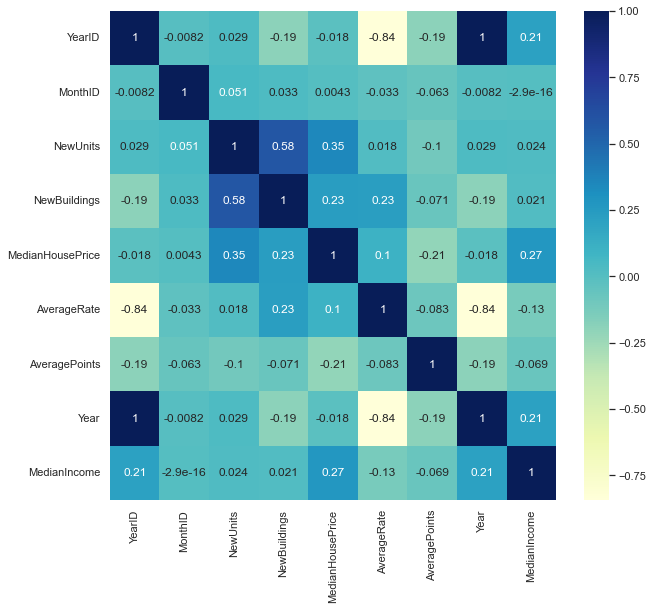

In [33]:
sns.set(rc={"figure.figsize":(10, 9)})
dataplot = sns.heatmap(master_table.corr(), cmap="YlGnBu", annot=True)

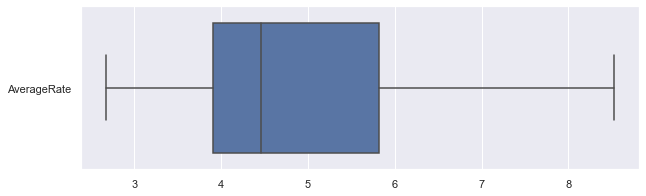

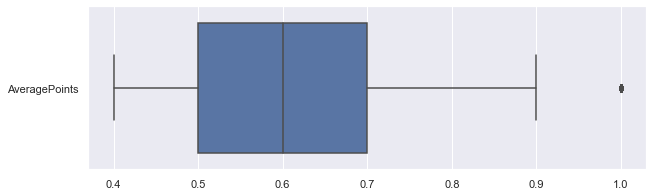

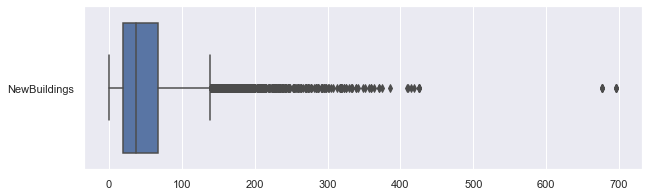

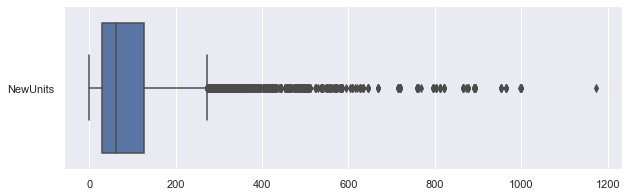

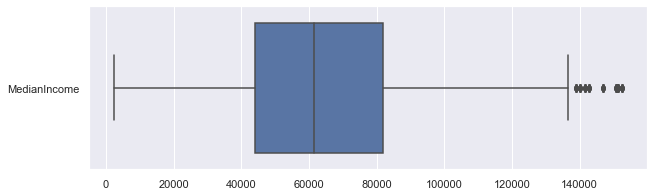

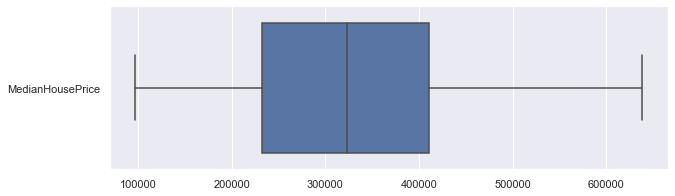

In [34]:
plt.rcParams["figure.figsize"] = (10,3)
sns.boxplot(data = master_table[['AverageRate']], orient="h")
plt.show()
sns.boxplot(data = master_table[['AveragePoints']], orient="h")
plt.show()
sns.boxplot(data = master_table[['NewBuildings']], orient="h")
plt.show()
sns.boxplot(data = master_table[['NewUnits']], orient="h")
plt.show()
sns.boxplot(data = master_table[['MedianIncome']], orient="h")
plt.show()
sns.boxplot(data = master_table[['MedianHousePrice']], orient="h")
plt.show()

In [35]:
# finding nulls - because median income only goes to 2019, the other nulls can be dropped
null_counts = master_table.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

MedianIncome        1839
AgeGroup            1827
MedianHousePrice      21
dtype: int64

#### Calculating Affordability

In [36]:
# dropping nulls for ml model
final_table = master_table.dropna()

# calculate monthly income
final_table['MonthlyIncome'] = final_table['MedianIncome']/12

# calculate montly mortgage payment
#https://www.educba.com/mortgage-formula/

for row in final_table:
    P = final_table['MedianHousePrice']-(final_table['MedianHousePrice']*.2).copy()
    r = (final_table['AverageRate']/100)
    t = 30
    n = 12
    monthly_tax = (final_table['MedianHousePrice']*.0189)/12
    final_table['MonthlyMortgage'] = (P * (((r/n) * pow((1+(r/n)),(n*t))) / (pow((1+r/n),(n*t))-1))) + monthly_tax


# mortgage to income ratio
final_table['mortgage_income_ratio'] = final_table['MonthlyMortgage']/final_table['MonthlyIncome']

# affordability determination
def affordable_condition(x):
    if x <= .25:
        return 'Yes'
    elif np.isnan(x):
        return 'Missing'
    else:
        return 'No'

final_table['affordable'] = final_table['mortgage_income_ratio'].apply(affordable_condition)

C:\Users\hluong\AppData\Local\Temp\ipykernel_18216\2325480288.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hluong\AppData\Local\Temp\ipykernel_18216\2325480288.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hluong\AppData\Local\Temp\ipykernel_18216\2325480288.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [37]:
final_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome,MonthlyIncome,MonthlyMortgage,mortgage_income_ratio,affordable
60,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,25-44,52040.0,4336.666667,1551.736115,0.357818,No
61,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,45-64,62816.0,5234.666667,1551.736115,0.296435,No
62,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,65-plus,30697.0,2558.083333,1551.736115,0.606601,No
63,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,overall,50377.0,4198.083333,1551.736115,0.369630,No
64,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,under-25,28074.0,2339.500000,1551.736115,0.663277,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,25-44,86705.0,7225.416667,1307.795634,0.180999,Yes
20696,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,45-64,101995.0,8499.583333,1307.795634,0.153866,Yes
20697,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,65-plus,55687.0,4640.583333,1307.795634,0.281817,No
20698,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,overall,84479.0,7039.916667,1307.795634,0.185769,Yes


#### VISUALS
To answer questions and potentially be added to dashboard

In [38]:
# Highest income counties

incomes = master_table[['County','AgeGroup','MedianIncome']]
incomes = incomes[incomes['AgeGroup'] != 'overall']
incomes = incomes.groupby(by='County').agg('mean').reset_index().sort_values('MedianIncome',ascending=False)
top_5_income = incomes.head(5)
top_5_income = top_5_income.sort_values('MedianIncome',ascending=True)
# plotting
fig = px.bar(data_frame=top_5_income,x='MedianIncome',y='County',orientation='h',text_auto=True,width=900, height=500, title='Counties with Highest Overall Average Median Income')
fig.update_layout()
fig.show()

In [39]:
# plotting average median house price for all counties, all age group
# plotting average median income for all counties, all age group, 2020-2022 are predictions 

year_income = final_table[['Year','MedianIncome']]
year_income = year_income.groupby(by=['Year']).agg('mean')
year_income = year_income.reset_index()
year_hp = final_table[['Year','MedianHousePrice']]
year_hp = year_hp.groupby(by=['Year']).agg('mean')
year_hp = year_hp.reset_index()
year_income_hp = pd.merge(year_income,year_hp, on='Year', how='inner')
year_income_hp.reset_index()

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and Income over Time')
fig.add_scatter(x=year_income_hp['Year'],y=year_income_hp['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=year_income_hp['Year'],y=year_income_hp['MedianIncome'], name = 'Median Income')
fig.update_yaxes(title='Amount')
fig.update_xaxes(title='Year')
fig.show()


In [40]:
# Standarized to show relationship

variables = final_table[['Year','NewUnits','MedianHousePrice','AverageRate','MedianIncome']]
year = final_table[['Year']]
year = pd.DataFrame(data=year.Year.unique(),columns=['Year'])
new_var = variables.groupby(by='Year').agg('mean').reset_index()
sc_X = StandardScaler()
var_standard = sc_X.fit_transform(new_var[['NewUnits','MedianHousePrice','AverageRate','MedianIncome']])
var_standard = pd.DataFrame(data=var_standard, columns=['NewUnits','MedianHousePrice','AverageRate','MedianIncome'])
var_standard = pd.concat([var_standard.reset_index(drop=True), year], axis=1)
var_standard

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and Income over Time Standardized')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianIncome'], name = 'Median Income')
fig.update_yaxes(title='Standard Deviation')
fig.update_xaxes(title='Year')
fig.show()

In [41]:
# Percentage of Affordable Months by Year

all_year = pd.crosstab(final_table.Year,final_table.affordable)
# calculate percentage
all_year['percent_affordable'] = (all_year['Yes']/(all_year['Yes'] + all_year['No']))
all_year = all_year.sort_values('Year')
all_year = all_year.reset_index()


fig = px.bar(data_frame=all_year,x='Year',y='percent_affordable',\
    labels={'percent_affordable': 'Percentage of Affordable Months'},\
    text_auto='.0%',title='Percentage of Affordable Months by Year', width=1000, height=500)
fig.update_xaxes(tickangle=30,tickvals=all_year['Year'])
fig.update_traces(textposition='outside')
fig.show()

In [42]:
# Most and Least Affordable Counties

all_counties = pd.crosstab(final_table.County,final_table.affordable)

# calculate percentage
all_counties['percent_affordable'] = (all_counties['Yes']/(all_counties['Yes'] + all_counties['No']))
all_counties = all_counties.sort_values('percent_affordable')
all_counties = all_counties.reset_index()
top_5_counties = all_counties.tail(5)
bottom_10_counties = all_counties.head(10)
bottom_10_counties = bottom_10_counties.sort_values('percent_affordable',ascending=False)

# plot most affordable counties
fig = px.bar(data_frame=top_5_counties, x='percent_affordable',y='County',orientation='h',\
    width=600, height=400, title='Five Most Affordable Counties in New Jersey',\
        labels={'percent_affordable': 'Percentage of Affordable Months'},text_auto='.0%')
fig.update_xaxes(tickformat='.0%')

fig.show()

# plot least affordable counties
fig = px.bar(data_frame=bottom_10_counties, x='percent_affordable',y='County',orientation='h',\
    width=800, height=500, title='Ten Least Affordable Counties in New Jersey',\
        labels={'percent_affordable': 'Percentage of Affordable Months'},text_auto='.1%')
fig.update_xaxes(tickformat='.0%')

fig.show()

In [43]:
# Income over Time

year_age_group = final_table[['Year','MedianIncome','AgeGroup']]
year_age_group = year_age_group.groupby(by=['AgeGroup','Year']).agg('mean')
year_age_group = year_age_group.reset_index()
year_age_group['AgeGroup'] = year_age_group['AgeGroup'].map({'under-25':'25 & under','25-44':'25-44', '45-64':'45-64','65-plus':'65+',\
    'overall':'Overall'})
year_age_group = year_age_group.sort_values(['AgeGroup','Year']) 

fig = px.line(data_frame=year_age_group,x='Year',y='MedianIncome', color='AgeGroup',\
    labels={'MedianIncome': 'Average Median Income'},\
    title='Median Income by Age Group over Time', width=1000, height=500)

fig.show()

In [44]:
# Plotting income changes over time for all age groups

year_age_group = final_table[['Year','County','mortgage_income_ratio','AgeGroup']]
year_age_group = year_age_group.groupby(by=['Year','County','AgeGroup']).agg('mean')
year_age_group = year_age_group.reset_index()
year_age_group['AgeGroup'] = year_age_group['AgeGroup'].map({'under-25':'25 & under','25-44':'25-44', '45-64':'45-64','65-plus':'65+',\
    'overall':'Overall'})
year_age_group = year_age_group.sort_values(['AgeGroup','Year']) 

for county in year_age_group['County'].unique():
    df = year_age_group[year_age_group['County'] == county]
    # ax = sns.lineplot(data=df, x='Year',y='mortgage_income_ratio', hue='AgeGroup')

    fig = px.line(data_frame=df,x='Year',y='mortgage_income_ratio', color='AgeGroup',\
        labels={'mortgage_income_ratio': 'Ratio of Mortgage to Income'},\
        title= f'Affordability by Age Group over Time - {county}', width=1000, height=500)
    fig.update_yaxes(tickformat='.0%')
    fig.show()

In [45]:
# Affordability by Age Group over Time

year_age_group = final_table[['Year','County','mortgage_income_ratio','AgeGroup']]
year_age_group = year_age_group.groupby(by=['AgeGroup','Year']).agg('mean')
year_age_group = year_age_group.reset_index()
year_age_group['AgeGroup'] = year_age_group['AgeGroup'].map({'under-25':'25 & under','25-44':'25-44', '45-64':'45-64','65-plus':'65+',\
    'overall':'Overall'})
year_age_group = year_age_group.sort_values(['AgeGroup','Year']) 

fig = px.line(data_frame=year_age_group,x='Year',y='mortgage_income_ratio', color='AgeGroup',\
    labels={'mortgage_income_ratio': 'Ratio of Mortgage to Income'},\
    title='Affordability by Age Group over Time', width=1000, height=500)
fig.update_yaxes(tickformat='.0%')
fig.show()

In [46]:
# Standardized all variables over Time

variables = master_table[['Year','NewUnits','MedianHousePrice','AverageRate','MedianIncome']]
year = master_table[['Year']]
year = pd.DataFrame(data=year.Year.unique(),columns=['Year'])
new_var = variables.groupby(by='Year').agg('mean').reset_index()
sc_X = StandardScaler()
var_standard = sc_X.fit_transform(new_var[['NewUnits','MedianHousePrice','AverageRate','MedianIncome']])
var_standard = pd.DataFrame(data=var_standard, columns=['NewUnits','MedianHousePrice','AverageRate','MedianIncome'])
var_standard = pd.concat([var_standard.reset_index(drop=True), year], axis=1)
var_standard


fig = px.line(width=1000, height=500,labels={'Year'}, title='Variables over Time')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianIncome'], name = 'Median Income')
fig.add_scatter(x=var_standard['Year'],y=var_standard['AverageRate'], name = 'Average Rate')
fig.add_scatter(x=var_standard['Year'],y=var_standard['NewUnits'], name = 'New Units')
fig.update_yaxes(title='Amount')
fig.update_xaxes(title='Year')
fig.show()

In [47]:
# New Units Constructions vs. Median House Price over Time

new_units = master_table[['Year','NewUnits']]
house_price = master_table[['Year','MedianHousePrice']]
# new_units['Year'] = new_units['Year']+2
new_units = new_units.groupby(by='Year').agg('mean').reset_index()
house_price = house_price.groupby(by='Year').agg('mean').reset_index()
units_house_price = pd.merge(new_units,house_price, on='Year',how='inner')

year = pd.DataFrame(data=units_house_price.Year.unique(),columns=['Year'])
sc_X = StandardScaler()
var_standard = sc_X.fit_transform(units_house_price[['NewUnits','MedianHousePrice']])
u_hp_sd = pd.DataFrame(data=var_standard, columns=['NewUnits','MedianHousePrice'])
units_house_price = pd.concat([u_hp_sd.reset_index(drop=True), year], axis=1)
units_house_price

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and New Building Permits over Time')
fig.add_scatter(x=units_house_price['Year'],y=units_house_price['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=units_house_price['Year'],y=units_house_price['NewUnits'], name = 'New Units')
fig.update_yaxes(title='Standard Deviation')
fig.update_xaxes(title='Year')
fig.show()

In [48]:
# Staggered buildings by 2 years

new_units = master_table[['Year','NewUnits']]
house_price = master_table[['Year','MedianHousePrice']]
new_units['Year'] = new_units['Year']+2
new_units = new_units.groupby(by='Year').agg('mean').reset_index()
house_price = house_price.groupby(by='Year').agg('mean').reset_index()
units_house_price = pd.merge(new_units,house_price, on='Year',how='inner')

year = pd.DataFrame(data=units_house_price.Year.unique(),columns=['Year'])
sc_X = StandardScaler()
var_standard = sc_X.fit_transform(units_house_price[['NewUnits','MedianHousePrice']])
u_hp_sd = pd.DataFrame(data=var_standard, columns=['NewUnits','MedianHousePrice'])
units_house_price = pd.concat([u_hp_sd.reset_index(drop=True), year], axis=1)
units_house_price

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and New Building Permits over Time')
fig.add_scatter(x=units_house_price['Year'],y=units_house_price['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=units_house_price['Year'],y=units_house_price['NewUnits'], name = 'New Units')
fig.update_yaxes(title='Standard Deviation')
fig.update_xaxes(title='Year')
fig.show()

C:\Users\hluong\AppData\Local\Temp\ipykernel_18216\3378542986.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Adding in predictions from ARIMA for 2020-2022 and repeating visuals

In [49]:
# year 2020-2022 aggregated
predicted_years = master_table[(master_table['Year'] == 2020) | (master_table['Year'] == 2021) | (master_table['Year'] == 2022)]
predicted_df = predicted_years[['FIPS','Year','YearID','County','MedianHousePrice','AverageRate','AveragePoints']].groupby(by=['FIPS','Year','County']).agg('mean').reset_index()
predicted_df['FIPS'] = predicted_df['FIPS'].astype('int64')


# reading in income predictions to predict 2020-2022
df = pd.read_csv('PredictedIncomeFinal.csv')
df = df[['Year','FIPS','AgeGroup','train_and_predicted']]
income_predictions = df[(df.Year == 2020)| (df.Year == 2021) | (df.Year == 2022)]
income_predictions.rename(columns={'train_and_predicted':'MedianIncome'},inplace=True)

# merging income predictions to get the rest of the data
main_predictions = pd.merge(predicted_df, income_predictions, on=['Year','FIPS'],how='inner')
main_predictions

# adding income predictions to main table
final_table = master_table.dropna()
# final_table = final_table[['FIPS','Year','County', 'YearID','MedianHousePrice', 'AverageRate', 'AveragePoints',
#        'AgeGroup','MedianIncome']]
final_table['YearID'] = final_table['YearID'].astype(int)
final_table = pd.concat([final_table,main_predictions])

e:\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hluong\AppData\Local\Temp\ipykernel_18216\920202204.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Calculating Affordability

In [50]:
# calculate monthly income
final_table['MonthlyIncome'] = final_table['MedianIncome']/12

# calculate montly mortgage payment
#https://www.educba.com/mortgage-formula/

for row in final_table:
    P = final_table['MedianHousePrice']-(final_table['MedianHousePrice']*.2).copy()
    r = (final_table['AverageRate']/100)
    t = 30
    n = 12
    monthly_tax = (final_table['MedianHousePrice']*.0189)/12
    final_table['MonthlyMortgage'] = (P * (((r/n) * pow((1+(r/n)),(n*t))) / (pow((1+r/n),(n*t))-1))) + monthly_tax


# mortgage to income ratio
final_table['mortgage_income_ratio'] = final_table['MonthlyMortgage']/final_table['MonthlyIncome']

# affordability determination
def affordable_condition(x):
    if x <= .25:
        return 'Yes'
    elif np.isnan(x):
        return 'Missing'
    else:
        return 'No'

final_table['affordable'] = final_table['mortgage_income_ratio'].apply(affordable_condition)

In [51]:
# Highest income counties

incomes = final_table[['County','AgeGroup','MedianIncome']]
incomes = incomes[incomes['AgeGroup'] != 'overall']
incomes = incomes.groupby(by='County').agg('mean').reset_index().sort_values('MedianIncome',ascending=False)
top_5_income = incomes.head(5)
top_5_income = top_5_income.sort_values('MedianIncome',ascending=True)
# plotting
fig = px.bar(data_frame=top_5_income,x='MedianIncome',y='County',orientation='h',text_auto=True,width=900, height=500, title='Counties with Highest Overall Average Median Income')
fig.update_layout()
fig.show()

In [52]:
# plotting average median house price for all counties, all age group
# plotting average median income for all counties, all age group, 2020-2022 are predictions 

year_income = final_table[['Year','MedianIncome']]
year_income = year_income.groupby(by=['Year']).agg('mean')
year_income = year_income.reset_index()
year_hp = final_table[['Year','MedianHousePrice']]
year_hp = year_hp.groupby(by=['Year']).agg('mean')
year_hp = year_hp.reset_index()
year_income_hp = pd.merge(year_income,year_hp, on='Year', how='inner')
year_income_hp.reset_index()

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and Income over Time')
fig.add_scatter(x=year_income_hp['Year'],y=year_income_hp['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=year_income_hp['Year'],y=year_income_hp['MedianIncome'], name = 'Median Income')
fig.update_yaxes(title='Amount')
fig.update_xaxes(title='Year')
fig.show()

In [53]:
# Standarized to show relationship

variables = final_table[['Year','NewUnits','MedianHousePrice','AverageRate','MedianIncome']]
year = final_table[['Year']]
year = pd.DataFrame(data=year.Year.unique(),columns=['Year'])
new_var = variables.groupby(by='Year').agg('mean').reset_index()
sc_X = StandardScaler()
var_standard = sc_X.fit_transform(new_var[['NewUnits','MedianHousePrice','AverageRate','MedianIncome']])
var_standard = pd.DataFrame(data=var_standard, columns=['NewUnits','MedianHousePrice','AverageRate','MedianIncome'])
var_standard = pd.concat([var_standard.reset_index(drop=True), year], axis=1)
var_standard

fig = px.line(width=1000, height=500,labels={'Year'}, title='Median House Price and Income over Time Standardized')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianHousePrice'], name = 'Median House Price')
fig.add_scatter(x=var_standard['Year'],y=var_standard['MedianIncome'], name = 'Median Income')
fig.update_yaxes(title='Standard Deviation')
fig.update_xaxes(title='Year')
fig.show()

In [54]:
# Percentage of Affordable Months by Year

all_year = pd.crosstab(final_table.Year,final_table.affordable)
# calculate percentage
all_year['percent_affordable'] = (all_year['Yes']/(all_year['Yes'] + all_year['No']))
all_year = all_year.sort_values('Year')
all_year = all_year.reset_index()


fig = px.bar(data_frame=all_year,x='Year',y='percent_affordable',\
    labels={'percent_affordable': 'Percentage of Affordable Months'},\
    text_auto='.0%',title='Percentage of Affordable Months by Year', width=1000, height=500)
fig.update_xaxes(tickangle=30,tickvals=all_year['Year'])
fig.update_traces(textposition='outside')
fig.show()

In [55]:
# Most and Least Affordable Counties

all_counties = pd.crosstab(final_table.County,final_table.affordable)

# calculate percentage
all_counties['percent_affordable'] = (all_counties['Yes']/(all_counties['Yes'] + all_counties['No']))
all_counties = all_counties.sort_values('percent_affordable')
all_counties = all_counties.reset_index()
bottom_10_counties = all_counties.head(10)
top_5_counties = all_counties.tail(5)
bottom_10_counties = bottom_10_counties.sort_values('percent_affordable',ascending=False)

# plot most affordable counties
fig = px.bar(data_frame=top_5_counties, x='percent_affordable',y='County',orientation='h',\
    width=600, height=400, title='Five Most Affordable Counties in New Jersey',\
        labels={'percent_affordable': 'Percentage of Affordable Months'},text_auto='.0%')
fig.update_xaxes(tickformat='.0%')

fig.show()

# plot least affordable counties
fig = px.bar(data_frame=bottom_10_counties, x='percent_affordable',y='County',orientation='h',\
    width=800, height=500, title='Ten Least Affordable Counties in New Jersey',\
        labels={'percent_affordable': 'Percentage of Affordable Months'},text_auto='.1%')
fig.update_xaxes(tickformat='.0%')

fig.show()

In [56]:
# Affordability by Age Group over Time

year_age_group = final_table[['Year','County','mortgage_income_ratio','AgeGroup']]
year_age_group = year_age_group.groupby(by=['AgeGroup','Year']).agg('mean')
year_age_group = year_age_group.reset_index()
year_age_group['AgeGroup'] = year_age_group['AgeGroup'].map({'under-25':'25 & under','25-44':'25-44', '45-64':'45-64','65-plus':'65+',\
    'overall':'Overall'})
year_age_group = year_age_group.sort_values(['AgeGroup','Year']) 

fig = px.line(data_frame=year_age_group,x='Year',y='mortgage_income_ratio', color='AgeGroup',\
    labels={'mortgage_income_ratio': 'Ratio of Mortgage to Income'},\
    title='Affordability by Age Group over Time', width=1000, height=500)
fig.update_yaxes(tickformat='.0%')
fig.show()